# ResNet

Here is ResNet Woot Woot

# Load DataSets

In [1]:
import tensorflow as tf
import hyperopt as hpropt
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset, sample_data, plot_confusion_matrix
from model import Model, lazy_property
from config import ModelConfig, TrainConfig
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

In [2]:
# Form training, developement, and testing data sets
"""
address = r'../../data/smallDataset/'
file_names = {}
file_names['images'] = 'data.npy'
file_names['subs'] = 'subredditlabels'
file_names['dict'] = 'subredditIndex'
file_names['nsfw'] = 'nsfwlabels'
"""
address = r'../../data/fullData/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'

data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train labels shape: ', data.y_train.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation labels shape: ', data.y_val.shape)
print('Test data shape: ', data.X_test.shape)
print('Test labels shape: ', data.y_test.shape)

Train data shape:  (25450, 128, 128, 3)
Train labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test labels shape:  (3182,)


In [3]:
# Number of different convolutions
NdistinctConvLayers = 2
# Number of layers for each different convolution
Nlayers = [2, 2, 2, 2]
# Number of filters for each different convolution
Nfilters = [64, 128, 256, 512]
# Size of filters
kernelSizes = [3, 3]

model_config = ModelConfig(learning_rate=5e-4, eval_batch_size=100, output="nsfw")

model_config.RS_NdistinctConvLayers = NdistinctConvLayers
model_config.RS_Nlayers = Nlayers
model_config.RS_Nfilters = Nfilters
model_config.RS_kernelSizes = kernelSizes

In [4]:
class ResNet(Model):
    
    def __init__(self, model_config):
        Model.__init__(self, model_config)
    
    @lazy_property
    def prediction(self):
        
        conv_init = tf.layers.conv2d(
                    inputs = self.X_placeholder,
                    filters = 64,
                    kernel_size = [7, 7],
                    strides = 2,
                    padding = "same")
    
        block_input = tf.layers.max_pooling2d(
                    inputs = conv_init,
                    pool_size = [2, 2],
                    strides = 2)
    
        for idl in range(self.config.RS_NdistinctConvLayers) :
            if (idl == 0) :
                firstStride = 1
            else :
                firstStride = 2
            
            conv = tf.layers.conv2d(
                        inputs = block_input,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[0],
                        strides = firstStride,
                        padding = "same")
            convBN = tf.layers.batch_normalization(
                        conv, 
                        training=self.is_training_placeholder)        
            relu = tf.nn.relu(convBN)
            residual = tf.layers.conv2d(
                        inputs = relu,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[1],
                        strides = 1,
                        padding = "same")
            residualBN = tf.layers.batch_normalization(
                        residual, 
                        training=self.is_training_placeholder)
            block_input = tf.nn.relu(residualBN)
        
            for ilr in range(self.config.RS_Nlayers[idl] - 1) :
            
                conv = tf.layers.conv2d(
                            inputs = block_input,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[0],
                            strides = 1,
                            padding = "same")
                convBN = tf.layers.batch_normalization(
                            conv, 
                            training=self.is_training_placeholder)        
                relu = tf.nn.relu(convBN)
                residual = tf.layers.conv2d(
                            inputs = relu,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[1],
                            strides = 1,
                            padding = "same")
                residualBN = tf.layers.batch_normalization(
                            residual, 
                            training=self.is_training_placeholder)        
                output = block_input + residualBN
                outputBN = tf.layers.batch_normalization(
                            output, 
                            training=self.is_training_placeholder)
                block_input = tf.nn.relu(outputBN)
            
        convRes = tf.layers.batch_normalization(
                    block_input, 
                    training=self.is_training_placeholder)
    
        shape = convRes.get_shape().as_list()
        avgPool = tf.nn.avg_pool(
                    value=convRes, 
                    ksize=[1,shape[1],shape[2],1],
                    strides=[1,1,1,1],
                    padding='VALID')
    
        shape = avgPool.get_shape().as_list()
        avgPool_flat = tf.reshape(avgPool,[-1, shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(inputs=avgPool_flat, units=2)

        return logits

# Reload Parameters

In [14]:
# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(learning_rate=5e-4, eval_batch_size=100, output="nsfw")
train_config = TrainConfig(num_epochs=1, 
                            train_batch_size=64, 
                            print_every=100, 
                            lr_decay = 0.9,
                            saver_address=r'../../parameters/', \
                            save_file_name = 'ResNet_nsfw_classification')
model = ResNet(model_config)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, train_config.saver_address + train_config.save_file_name) 

# Test Model Accuracy
#loss_train, acc_train_sub, acc_train_nsfw = model.eval(data, session, split='train')
#loss_val, acc_val_sub, acc_val_nsfw = model.eval(data, session, split = 'val')

InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [64,2] rhs shape= [256,2]
	 [[Node: save/Assign_20 = Assign[T=DT_FLOAT, _class=["loc:@dense/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dense/kernel/Adam, save/RestoreV2_20/_7)]]

Caused by op 'save/Assign_20', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-5f099a4d21c4>", line 16, in <module>
    saver = tf.train.Saver()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 414, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [64,2] rhs shape= [256,2]
	 [[Node: save/Assign_20 = Assign[T=DT_FLOAT, _class=["loc:@dense/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dense/kernel/Adam, save/RestoreV2_20/_7)]]


# Train the Model

In [17]:
# Create model instance
tf.reset_default_graph()

train_config = TrainConfig(num_epochs=20, 
                    train_batch_size=64, 
                    print_every=100, 
                    lr_decay = 0.9,
                    saver_address=r'../../parameters/',
                    save_file_name = 'ResNet_nsfw_classification2')
model = ResNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 16.326101 seconds
Batch 200/398 of epoch 1 finished in 15.700363 seconds
Batch 300/398 of epoch 1 finished in 15.683678 seconds
Epoch 1 training finished in 63.442555 seconds
train accuracy:93.3%
val accuracy:94.3%
Epoch 1 evaluation finished in 14.077425 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 15.611723 seconds
Batch 200/398 of epoch 2 finished in 15.619421 seconds
Batch 300/398 of epoch 2 finished in 15.563102 seconds
Epoch 2 training finished in 61.980622 seconds
train accuracy:91.7%
val accuracy:91.3%
Epoch 2 evaluation finished in 13.589577 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 15.552209 seconds
Batch 200/398 of epoch 3 finished in 15.568662 seconds
Batch 300/398 of epoch 3 finished in 15.582646 seconds
Epoch 3 training finished in 61.907011 seconds
train accura

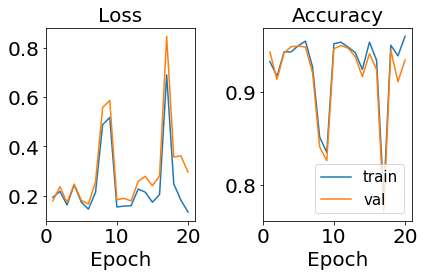

In [30]:
# Plot Loss and Accuracy
model.plot_loss_acc(data, save_address = '../../plots/', save_name = 'nsfw_history', \
    title_font = 20, tick_font = 20, legend_font = 15, axis_font = 20)

# Confusion Matrix

In [25]:
y_val_pred = session.run(model.prediction, {model.X_placeholder: data.X_val, 
                                            model.y_placeholder: data.y_val_2, 
                                            model.is_training_placeholder:False})
y_val_pred = np.argmax(y_val_pred, axis = 1)

Normalized confusion matrix


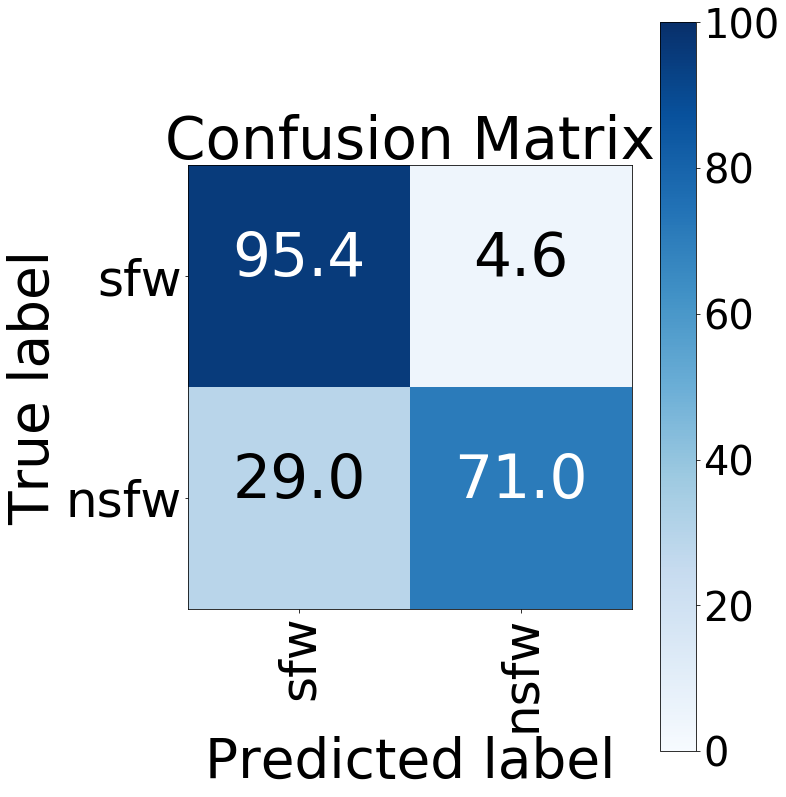

In [31]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_val_2, y_val_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True, figure_size = 11, tick_font = 50, box_font = 60, \
    axis_font = 55, title_font = 58, colorbar_font = 40,\
    left_space = 0.25, right_space = 0.95, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../plots/', save_name = 'nsfw_confusion_nsfw')

# Evaluate on Test

In [32]:
cost, accuracy = model.eval(data, session, "test")

test accuracy:93.1%


### Confusion Matrix

In [33]:
y_test_pred = session.run(model.prediction, {model.X_placeholder: data.X_test, 
                                            model.y_placeholder: data.y_test_2, 
                                            model.is_training_placeholder:False})
y_test_pred = np.argmax(y_test_pred, axis = 1)

Normalized confusion matrix


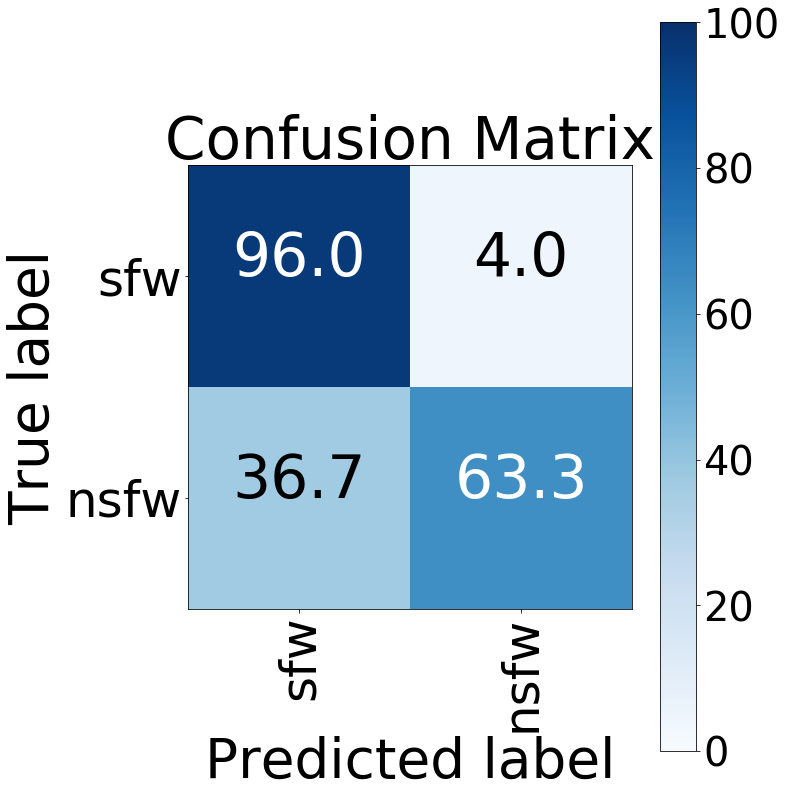

In [35]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_test_2, y_test_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True, figure_size = 11, tick_font = 50, box_font = 60, \
    axis_font = 55, title_font = 58, colorbar_font = 40,\
    left_space = 0.25, right_space = 0.95, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../plots/', save_name = 'test_nsfw_confusion')

# Hyperparameter Search

In [5]:
train_config = TrainConfig(num_epochs=8, 
                    train_batch_size=64, 
                    print_every=1000)
modelHP = ResNet(model_config)
session = tf.Session()

def objective(args):

    tf.reset_default_graph()
    modelHP = ResNet(model_config)
    session = tf.Session()
    
    #train_config.num_epochs = args['Nepochs']
    train_config.lr_decay = args['decayRate']
    modelHP.config.learning_rate = args['learningRate']
    
    modelHP.train(data, session, train_config)
    cost, accuracy = modelHP.eval(data, session, "val")
    
    saveList = {
        'accuracy' : accuracy,
        'cost' : cost,
        #'Nepochs' : args['Nepochs'],
        'learningRate' : args['learningRate'],
        'decayRate' : args['decayRate']
    }    
    pickle.dump(saveList, open("../../hprOpt/nsfw/hprPrmOpt_nsfw_" + str(accuracy) + "_" + str(cost) + ".dat", "wb"))
    
    return cost

def optimize():
    
    space = {
        #'Nepochs' : hpropt.hp.randint('Nepochs', 10),
        'learningRate' : hpropt.hp.loguniform('learningRate', -15, -4),
        'decayRate' : hpropt.hp.uniform('decayRate', 0.9, 1)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=500)
    print(best)
    
    return best

In [6]:
optimize()

---------------------------------------------------------
Epoch 1 training finished in 64.707372 seconds
train accuracy:73.6%
val accuracy:73.5%
Epoch 1 evaluation finished in 13.849769 seconds
---------------------------------------------------------
Epoch 2 training finished in 62.435393 seconds
train accuracy:77.6%
val accuracy:77.5%
Epoch 2 evaluation finished in 13.300302 seconds
---------------------------------------------------------
Epoch 3 training finished in 62.416721 seconds
train accuracy:73.9%
val accuracy:73.4%
Epoch 3 evaluation finished in 13.313330 seconds
---------------------------------------------------------
Epoch 4 training finished in 62.302669 seconds
train accuracy:80.2%
val accuracy:79.6%
Epoch 4 evaluation finished in 13.505154 seconds
---------------------------------------------------------
Epoch 5 training finished in 62.428310 seconds
train accuracy:87.6%
val accuracy:87.3%
Epoch 5 evaluation finished in 13.420753 seconds
------------------------------

KeyboardInterrupt: 